# Anti-Money Laundering Detector Model

In [1]:
import os
import json
import zipfile
from pyspark.sql import SparkSession
import random
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, when, count, avg, to_timestamp, hour, dayofweek
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql import Window
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
%pip install kaggle

In [ ]:
#os.environ['KAGGLE_CONFIG_DIR'] = '/dbfs/FileStore'
#dbutils.fs.mkdirs("/FileStore/kaggle_data")
#!kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml -p /dbfs/FileStore/kaggle_data --force

In [2]:
#(Replace Databrick) - Replace dbutils.fs.mkdirs with os.makedirs
os.makedirs("/FileStore/kaggle_data", exist_ok=True)

In [3]:
# (Replace Databrick)
os.environ['KAGGLE_CONFIG_DIR'] = './kaggle_config'  # Local directory

In [ ]:
# (Replace Databrick) -
os.makedirs("./kaggle_data", exist_ok=True)  # Create a local directory
# Download the dataset from kaggle
os.system("kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml -p ./kaggle_data --force")

In [5]:
# Extact the file if it does not exists
import zipfile
import os
from pyspark.sql.types import StructType, StructField, StringType, FloatType

def extract_csv_file(zip_path, file_name, extract_path, final_local_path):
    # Check if the file already exists
    if os.path.exists(final_local_path):
        print(f"File already exists at {final_local_path}. Skipping extraction.")
    else:
        # Extract the specific file from the zip
        with zipfile.ZipFile(zip_path, 'r') as z:
            if file_name in z.namelist():
                # Extract the file to a local path
                extracted_file_path = os.path.join(extract_path, file_name)
                z.extract(file_name, extract_path)
                print(f"File extracted to {extracted_file_path}")

                # Move the file to the final local path (if needed)
                os.rename(extracted_file_path, final_local_path)
                print(f"File moved to {final_local_path}")
            else:
                print(f"{file_name} not found in the zip file.")
                return None

    # Define schema for the transactions
    schema = StructType([
        StructField("Timestamp", StringType(), True),
        StructField("From_Bank", StringType(), True),
        StructField("From_Account", StringType(), True),
        StructField("To_Bank", StringType(), True),
        StructField("To_Account", StringType(), True),
        StructField("Amount_Received", FloatType(), True),
        StructField("Receiving_Currency", StringType(), True),
        StructField("Amount_Paid", FloatType(), True),
        StructField("Payment_Currency", StringType(), True),
        StructField("Payment_Format", StringType(), True)
    ])

    # Initialize Spark session (if not already initialized)
    spark = SparkSession.builder.appName("LocalCSVReader").getOrCreate()

    # Read the file into a DataFrame
    df = spark.read.csv(final_local_path, schema=schema, header=True)

    return df

In [6]:
# (Replace Databrick) - Create local directories before extract the data 
import os
os.makedirs("kaggle_data/extracted", exist_ok=True)
os.makedirs("output", exist_ok=True)

In [7]:
# (Replace Databrick) - Update the paths for local use
hi_medium_df = extract_csv_file(
    zip_path="kaggle_data/ibm-transactions-for-anti-money-laundering-aml.zip",  # Local path to the zip file
    file_name="HI-Medium_Trans.csv",  # File name inside the zip
    extract_path="kaggle_data/extracted",  # Local directory for extraction
    final_local_path="output/HI-Medium_Trans.csv"  # Local path for the final CSV
)

File already exists at output/HI-Medium_Trans.csv. Skipping extraction.


In [8]:
 # (Replace Databrick)
li_medium_df = extract_csv_file(
    zip_path="kaggle_data/ibm-transactions-for-anti-money-laundering-aml.zip",  # Local path to the zip file
    file_name="LI-Medium_Trans.csv",  # File name inside the zip
    extract_path="kaggle_data/extracted",  # Local directory for extraction
    final_local_path="output/LI-Medium_Trans.csv"  # Local path for the final CSV
)

File already exists at output/LI-Medium_Trans.csv. Skipping extraction.


### Combine HI-Medium and LI-Medium
for real world scenario

In [9]:
# Combine both datasets
combined_df = hi_medium_df.union(li_medium_df)

In [12]:
# Extract the files if not exist
import os
import zipfile

# Initialize Spark session (if not already initialized)
spark = SparkSession.builder.appName("LocalTextReader").getOrCreate()

def extract_text(zip_path, file_name, extract_path, final_local_path):
    # Check if the file already exists
    if os.path.exists(final_local_path):
        print(f"File already exists at {final_local_path}. Skipping extraction.")
    else:
        # Extract the specific file from the zip
        with zipfile.ZipFile(zip_path, 'r') as z:
            if file_name in z.namelist():
                # Extract the file to the specified local path
                extracted_file_path = os.path.join(extract_path, file_name)
                z.extract(file_name, extract_path)
                print(f"File extracted to {extracted_file_path}")

                # Move the file to the final local path (if needed)
                os.rename(extracted_file_path, final_local_path)
                print(f"File moved to {final_local_path}")
            else:
                print(f"{file_name} not found in the zip file.")
                return None

    # Read the file into a Spark DataFrame
    df = spark.read.text(final_local_path)

    return df

In [13]:
# Load both pattern files

#(Replace Databrick) - Define paths for local use 
hi_patterns_df = extract_text(
    zip_path="kaggle_data/ibm-transactions-for-anti-money-laundering-aml.zip",  # Local path to the zip file
    file_name="HI-Medium_Patterns.txt",  # File name inside the zip
    extract_path="kaggle_data/extracted",  # Local directory for extraction
    final_local_path="output/HI-Medium_Patterns.txt"  # Local path for the final extracted file
)

li_patterns_df = extract_text(
    zip_path="kaggle_data/ibm-transactions-for-anti-money-laundering-aml.zip",  # Local path to the zip file
    file_name="LI-Medium_Patterns.txt",  # File name inside the zip
    extract_path="kaggle_data/extracted",  # Local directory for extraction
    final_local_path="output/LI-Medium_Patterns.txt"  # Local path for the final extracted file
)

File already exists at output/HI-Medium_Patterns.txt. Skipping extraction.
File already exists at output/LI-Medium_Patterns.txt. Skipping extraction.


In [14]:
# Union both pattern DataFrames
patterns_df = hi_patterns_df.union(li_patterns_df)

In [15]:
# (Replace Databrick) - This replace Databricks display

# Cache the DataFrame
patterns_df.cache()

# Show the data (use this in place of display)
patterns_df.show()  # Displays the top rows of the DataFrame

# Optionally count the rows to confirm caching works
print(f"Number of rows in patterns_df: {patterns_df.count()}")

+--------------------+
|               value|
+--------------------+
|BEGIN LAUNDERING ...|
|2022/09/01 05:14,...|
|2022/09/03 13:09,...|
|2022/09/01 07:40,...|
|2022/09/01 14:19,...|
|2022/09/02 12:40,...|
|2022/09/03 06:34,...|
|END LAUNDERING AT...|
|                    |
|BEGIN LAUNDERING ...|
|2022/09/01 00:19,...|
|2022/09/01 19:35,...|
|2022/09/02 02:58,...|
|2022/09/02 18:02,...|
|2022/09/03 07:16,...|
|2022/09/03 11:39,...|
|2022/09/03 12:04,...|
|2022/09/04 07:27,...|
|2022/09/04 08:38,...|
|2022/09/05 13:23,...|
+--------------------+
only showing top 20 rows

Number of rows in patterns_df: 36288


### Identify Laundering Patterns:
Each laundering attempt begins with BEGIN LAUNDERING ATTEMPT - [PATTERN] and ends with END LAUNDERING ATTEMPT.

Used regex to extract pattern types (e.g., Fan-Out, Cycle, Gather-Scatter, Stack) and transaction details.

In [16]:
# (Replace Databrick) - Correct the Databricks
# Step 1: Extract Pattern_Type where there is "BEGIN LAUNDERING ATTEMPT"
patterns_df = patterns_df.withColumn(
    "Pattern_Type",
    F.when(F.col("value").rlike("BEGIN LAUNDERING ATTEMPT - (.+)"),
           F.regexp_extract(F.col("value"), "BEGIN LAUNDERING ATTEMPT - (.+)", 1))
     .otherwise(None)
)

# Step 2: Forward fill the Pattern_Type to propagate it down until "END LAUNDERING ATTEMPT"
window_spec = Window.orderBy(F.monotonically_increasing_id()).rowsBetween(Window.unboundedPreceding, 0)
patterns_df = patterns_df.withColumn(
    "Pattern_Type",
    F.last("Pattern_Type", True).over(window_spec)
)

# Step 3: Filter out rows with "END LAUNDERING ATTEMPT" as they only mark the end of an attempt
patterns_df = patterns_df.filter(~F.col("value").contains("END LAUNDERING ATTEMPT"))


In [17]:
# (Replace Databrick) - Display the results
patterns_df.show(truncate=False)  # Show the DataFrame without truncating long strings

+------------------------------------------------------------------------------------------------+-------------------+
|value                                                                                           |Pattern_Type       |
+------------------------------------------------------------------------------------------------+-------------------+
|BEGIN LAUNDERING ATTEMPT - STACK                                                                |STACK              |
|2022/09/01 05:14,00952,8139F54E0,0111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1    |STACK              |
|2022/09/03 13:09,0111632,8062C56E0,008456,81363F620,5602.59,US Dollar,5602.59,US Dollar,ACH,1   |STACK              |
|2022/09/01 07:40,0118693,823D5EB90,013729,801CF2E60,1400.54,US Dollar,1400.54,US Dollar,ACH,1   |STACK              |
|2022/09/01 14:19,013729,801CF2E60,0123621,81A7090F0,1467.94,US Dollar,1467.94,US Dollar,ACH,1   |STACK              |
|2022/09/02 12:40,0024750,81363F410,0213834,8087

In [18]:
# Remove any text after the colon in Pattern_Type if it exists
patterns_df = patterns_df.withColumn(
    "Pattern_Type",
    F.regexp_replace(F.col("Pattern_Type"), ":.*", "")
)

# Display the DataFrame (use .show() in local PySpark)
patterns_df.show(truncate=False)

+------------------------------------------------------------------------------------------------+------------+
|value                                                                                           |Pattern_Type|
+------------------------------------------------------------------------------------------------+------------+
|BEGIN LAUNDERING ATTEMPT - STACK                                                                |STACK       |
|2022/09/01 05:14,00952,8139F54E0,0111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1    |STACK       |
|2022/09/03 13:09,0111632,8062C56E0,008456,81363F620,5602.59,US Dollar,5602.59,US Dollar,ACH,1   |STACK       |
|2022/09/01 07:40,0118693,823D5EB90,013729,801CF2E60,1400.54,US Dollar,1400.54,US Dollar,ACH,1   |STACK       |
|2022/09/01 14:19,013729,801CF2E60,0123621,81A7090F0,1467.94,US Dollar,1467.94,US Dollar,ACH,1   |STACK       |
|2022/09/02 12:40,0024750,81363F410,0213834,808757B00,16898.29,US Dollar,16898.29,US Dollar,ACH,1|STACK 

In [19]:
# Filter to get only transaction lines and ignore start/end laundering attempt lines
laundering_transactions = patterns_df.filter(patterns_df.value.rlike(r'\d{4}/\d{2}/\d{2}'))

# Unpersist patterns_df to free memory
patterns_df.unpersist()

# Cache laundering_transactions for reuse
laundering_transactions.cache()

# Display the filtered DataFrame (use .show() instead of display())
laundering_transactions.show(truncate=False)

+------------------------------------------------------------------------------------------------+------------+
|value                                                                                           |Pattern_Type|
+------------------------------------------------------------------------------------------------+------------+
|2022/09/01 05:14,00952,8139F54E0,0111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1    |STACK       |
|2022/09/03 13:09,0111632,8062C56E0,008456,81363F620,5602.59,US Dollar,5602.59,US Dollar,ACH,1   |STACK       |
|2022/09/01 07:40,0118693,823D5EB90,013729,801CF2E60,1400.54,US Dollar,1400.54,US Dollar,ACH,1   |STACK       |
|2022/09/01 14:19,013729,801CF2E60,0123621,81A7090F0,1467.94,US Dollar,1467.94,US Dollar,ACH,1   |STACK       |
|2022/09/02 12:40,0024750,81363F410,0213834,808757B00,16898.29,US Dollar,16898.29,US Dollar,ACH,1|STACK       |
|2022/09/03 06:34,0213834,808757B00,000,800073EF0,17607.19,US Dollar,17607.19,US Dollar,ACH,1    |STACK 

In [20]:
# Updated Code for Better Readability
columns = [
    "Timestamp", "From_Bank", "From_Account", "To_Bank", "To_Account",
    "Amount_Received", "Receiving_currency", "Amount_paid", 
    "Payment_currency", "Payment_Format", "isLaundering"
]

for idx, col_name in enumerate(columns):
    laundering_transactions = laundering_transactions.withColumn(col_name, F.split(F.col("value"), ",").getItem(idx))

In [ ]:
# Display the results
laundering_transactions.show(truncate=False)

+------------------------------------------------------------------------------------------------+------------+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+
|value                                                                                           |Pattern_Type|Timestamp       |From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_currency|Amount_paid|Payment_currency|Payment_Format|isLaundering|
+------------------------------------------------------------------------------------------------+------------+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+
|2022/09/01 05:14,00952,8139F54E0,0111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1    |STACK       |2022/09/01 05:14|00952    |8139F54E0   |0111632|8062C56E0 |5331.44        |US Dollar         |5331.4

In [ ]:
laundering_transactions = laundering_transactions.select("Timestamp", "From_Bank", "Pattern_Type", "isLaundering")

# Display the results
laundering_transactions.show(truncate=False)

+----------------+---------+------------+------------+
|Timestamp       |From_Bank|Pattern_Type|isLaundering|
+----------------+---------+------------+------------+
|2022/09/01 05:14|00952    |STACK       |1           |
|2022/09/03 13:09|0111632  |STACK       |1           |
|2022/09/01 07:40|0118693  |STACK       |1           |
|2022/09/01 14:19|013729   |STACK       |1           |
|2022/09/02 12:40|0024750  |STACK       |1           |
|2022/09/03 06:34|0213834  |STACK       |1           |
|2022/09/01 00:19|0134266  |CYCLE       |1           |
|2022/09/01 19:35|0036925  |CYCLE       |1           |
|2022/09/02 02:58|0119211  |CYCLE       |1           |
|2022/09/02 18:02|0132965  |CYCLE       |1           |
|2022/09/03 07:16|0137089  |CYCLE       |1           |
|2022/09/03 11:39|0216618  |CYCLE       |1           |
|2022/09/03 12:04|0024083  |CYCLE       |1           |
|2022/09/04 07:27|0038110  |CYCLE       |1           |
|2022/09/04 08:38|0225015  |CYCLE       |1           |
|2022/09/0

In [ ]:
# Count empty strings in each column
empty_string_counts = laundering_transactions.select(
    [sum(when(col(c) == "", 1).otherwise(0)).alias(c) for c in laundering_transactions.columns])

# (Replace Databrick)
# Show the result
empty_string_counts.show(truncate=False)

+---------+---------+------------+------------+
|Timestamp|From_Bank|Pattern_Type|isLaundering|
+---------+---------+------------+------------+
|0        |0        |0           |0           |
+---------+---------+------------+------------+



In [24]:
laundering_transactions.createOrReplaceTempView("combined")

In [ ]:
# Query using spark.sql()
result_df = spark.sql("""
    SELECT Pattern_Type, COUNT(Pattern_Type) AS count
    FROM combined
    GROUP BY Pattern_Type
""")

# Show the result
result_df.show(truncate=False)

+--------------+-----+
|Pattern_Type  |count|
+--------------+-----+
|STACK         |4601 |
|CYCLE         |2518 |
|FAN-IN        |2644 |
|GATHER-SCATTER|4830 |
|BIPARTITE     |2623 |
|FAN-OUT       |2617 |
|SCATTER-GATHER|4874 |
|RANDOM        |1945 |
+--------------+-----+



In [26]:
laundering_transactions.cache().groupBy("isLaundering").count().show()

+------------+-----+
|isLaundering|count|
+------------+-----+
|           1|26652|
+------------+-----+



### Create Labels for Laundering Transactions:¶
Joined the laundering pattern DataFrame (laundering_transactions) with the combined transaction DataFrame (combined_df) on transaction identifiers.

In [27]:
# Join the DataFrames on Timestamp, From_Bank, and To_Bank
joined_df = combined_df.join(
    laundering_transactions,
    on=["Timestamp", "From_Bank"],
    how="left"
)

#freeing from cache
combined_df.unpersist()
laundering_transactions.unpersist()

DataFrame[Timestamp: string, From_Bank: string, Pattern_Type: string, isLaundering: string]

In [28]:
# Fill null values in the `isLaundering` column with 0
joined_df = joined_df.withColumn(
    "isLaundering",
    F.when(F.col("isLaundering").isNull(), F.lit(0)).otherwise(F.col("isLaundering"))
)

In [29]:
# (- Replace Databrick) Cache the joined DataFrame 
joined_df.cache()

# Display the cached DataFrame (use .show() instead of .display())
joined_df.show(truncate=False)

+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+
|Timestamp       |From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|
+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+
|2022/09/01 00:17|020      |800104D70   |020    |800104D70 |6794.63        |US Dollar         |6794.63    |US Dollar       |Reinvestment  |NULL        |0           |
|2022/09/01 00:02|03196    |800107150   |03196  |800107150 |7739.29        |US Dollar         |7739.29    |US Dollar       |Reinvestment  |NULL        |0           |
|2022/09/01 00:17|01208    |80010E430   |01208  |80010E430 |1880.23        |US Dollar         |1880.23    |US Dollar       |Reinvestment  |NULL        |0           |
|202

In [30]:
# Convert 'isLaundering' from string to integer
joined_df = joined_df.withColumn("isLaundering", col("isLaundering").cast("integer"))


# Verify the schema change
joined_df.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From_Bank: string (nullable = true)
 |-- From_Account: string (nullable = true)
 |-- To_Bank: string (nullable = true)
 |-- To_Account: string (nullable = true)
 |-- Amount_Received: float (nullable = true)
 |-- Receiving_Currency: string (nullable = true)
 |-- Amount_Paid: float (nullable = true)
 |-- Payment_Currency: string (nullable = true)
 |-- Payment_Format: string (nullable = true)
 |-- Pattern_Type: string (nullable = true)
 |-- isLaundering: integer (nullable = true)



In [31]:
joined_df.groupBy("isLaundering").count().show()

+------------+--------+
|isLaundering|   count|
+------------+--------+
|           1|   84928|
|           0|63065007|
+------------+--------+



### Balance the data¶
DROP 50% of majority
Use SMOTE to generate synthetic data of minority after data engineering

In [32]:
# Register joined_df as a temporary view to use SQL
joined_df.createOrReplaceTempView("joined_table")

# Step 1: Identify rows to drop
# Here we assign a random value to each row that meets the condition, then select 50% of those rows
query = """
SELECT *
FROM joined_table
WHERE NOT ((Pattern_Type IS NULL) AND (isLaundering = 0) AND (rand() < 0.5))
"""

# Execute the SQL query
balanced_df = spark.sql(query)

In [33]:
joined_df.unpersist()

DataFrame[Timestamp: string, From_Bank: string, From_Account: string, To_Bank: string, To_Account: string, Amount_Received: float, Receiving_Currency: string, Amount_Paid: float, Payment_Currency: string, Payment_Format: string, Pattern_Type: string, isLaundering: int]

In [34]:
balanced_df.cache().groupBy("isLaundering").count().show()

+------------+--------+
|isLaundering|   count|
+------------+--------+
|           1|   84928|
|           0|31533404|
+------------+--------+



### Visualization of count by Laundering Status

In [35]:
# Function to visualize classes Is Laundry, Is not Launsdry

def visualize_group_counts_pyspark(spark_df):
    """
    Visualize the count of groups from a PySpark DataFrame using native PySpark methods
    
    Parameters:
    spark_df (pyspark.sql.DataFrame): The grouped and counted PySpark DataFrame
    """
    # Collect the data (be cautious with large datasets)
    grouped_data = spark_df.collect()
    
    # Extract labels and counts
    labels = []
    counts = []
    
    for row in grouped_data:
        labels.append(str(row['isLaundering']))
        counts.append(row['count'])
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts)
    plt.title('Count by Laundering Status', fontsize=14)
    plt.xlabel('Is Laundering', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Add count labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', 
                 ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

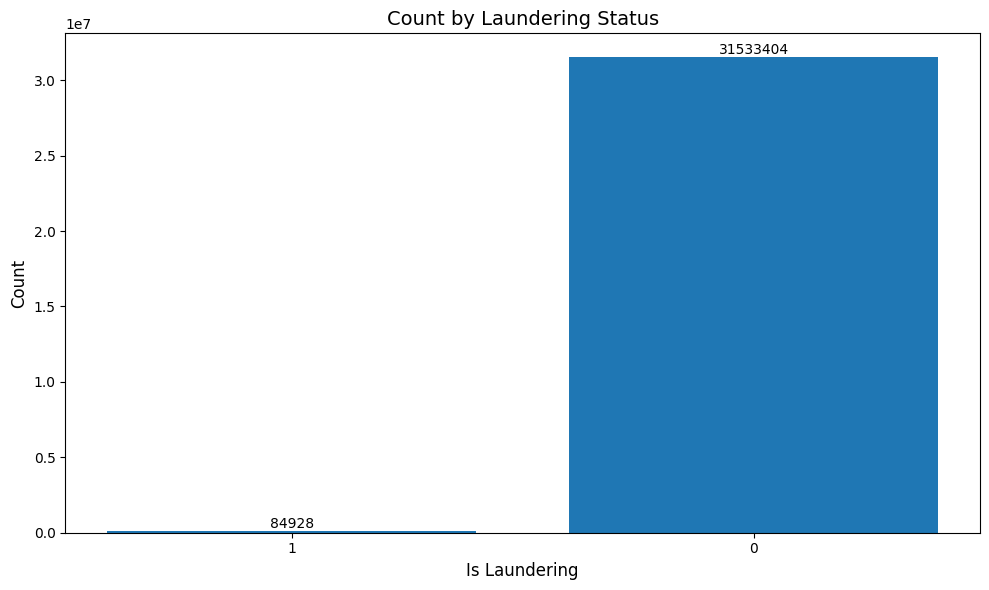

In [36]:
grouped_df = balanced_df.groupBy("isLaundering").count()
visualize_group_counts_pyspark(grouped_df)

### Data Cleaning and Exploration

In [37]:
# Count NULL values in each column
null_counts = balanced_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in balanced_df.columns])

# Show the result
null_counts.show()

+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+
|Timestamp|From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|
+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+
|        0|        0|           0|      0|         0|              0|                 0|          0|               0|             0|    31533404|           0|
+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+



In [38]:
balanced_df = balanced_df.na.fill({
    "Pattern_Type": "Unknown"
})

Extract features such as Hour and DayOfWeek

In [39]:
balanced_df = balanced_df.withColumn("Timestamp", to_timestamp("Timestamp", "yyyy/MM/dd HH:mm")) \
                         .withColumn("Hour", hour("Timestamp")) \
                         .withColumn("DayOfWeek", dayofweek("Timestamp"))

In [43]:
# (Replace Databrick) Show the final DataFrame (replacing .display() with .show())
balanced_df.show(truncate=False)

+-------------------+---------+------------+--------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+
|Timestamp          |From_Bank|From_Account|To_Bank |To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|Hour|DayOfWeek|
+-------------------+---------+------------+--------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+
|2022-09-01 00:02:00|03196    |800107150   |03196   |800107150 |7739.29        |US Dollar         |7739.29    |US Dollar       |Reinvestment  |Unknown     |0           |0   |5        |
|2022-09-01 00:02:00|01208    |80010E650   |020     |80010EA30 |4.5868456E7    |US Dollar         |4.5868456E7|US Dollar       |Cheque        |Unknown     |0           |0   |5        |
|2022-09-01 00:09:00|01208    |80010E430   |01208   |80010E430 |7.66       

### Total Amount Received by Day of the Week

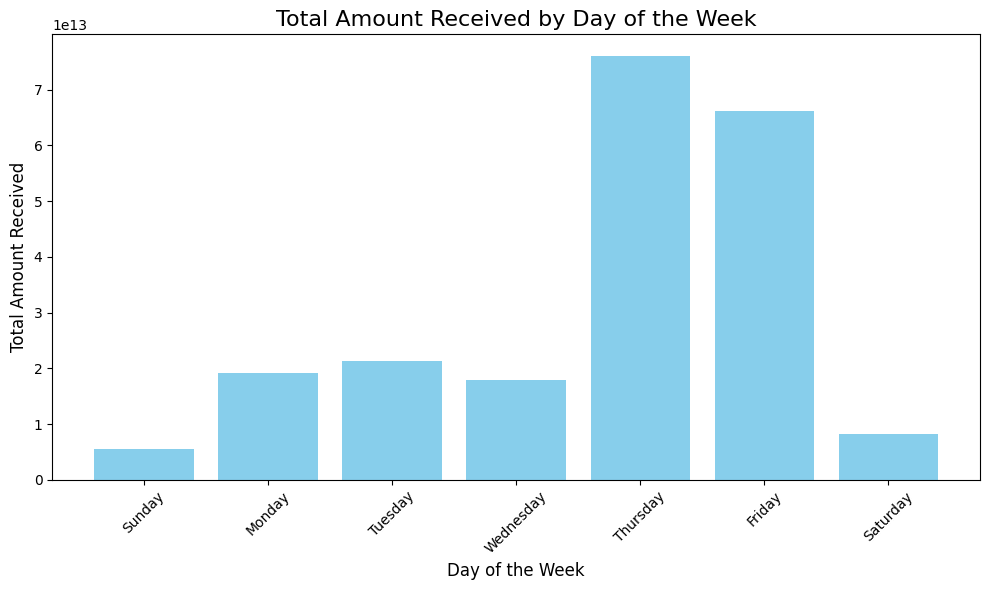

In [ ]:
from pyspark.sql import functions as F

# Group by DayOfWeek and calculate the total Amount_Received
amount_by_day = (
    balanced_df.groupBy("DayOfWeek")
    .agg(F.sum("Amount_Received").alias("Total_Amount"))
    .orderBy("DayOfWeek")
)

# Collect the data to prepare for plotting
data = amount_by_day.collect()

# Prepare data for the bar chart
days = [row["DayOfWeek"] for row in data]
amounts = [row["Total_Amount"] for row in data]

# Map DayOfWeek numbers to names (assuming 1 = Sunday, 7 = Saturday)
day_names = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday",
             5: "Thursday", 6: "Friday", 7: "Saturday"}
days_named = [day_names[day] for day in days]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(days_named, amounts, color="skyblue")
plt.title("Total Amount Received by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Total Amount Received", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [49]:
amount_by_day.show()

+---------+--------------------+
|DayOfWeek|        Total_Amount|
+---------+--------------------+
|        1|5.564488955702108E12|
|        2|1.917427846251759...|
|        3|2.128303069018168...|
|        4|1.783083415256800...|
|        5| 7.60927062490395E13|
|        6|6.608663299286294E13|
|        7| 8.16385670837665E12|
+---------+--------------------+



### Visualization Payment Format Distribution in Money Laundering Cases

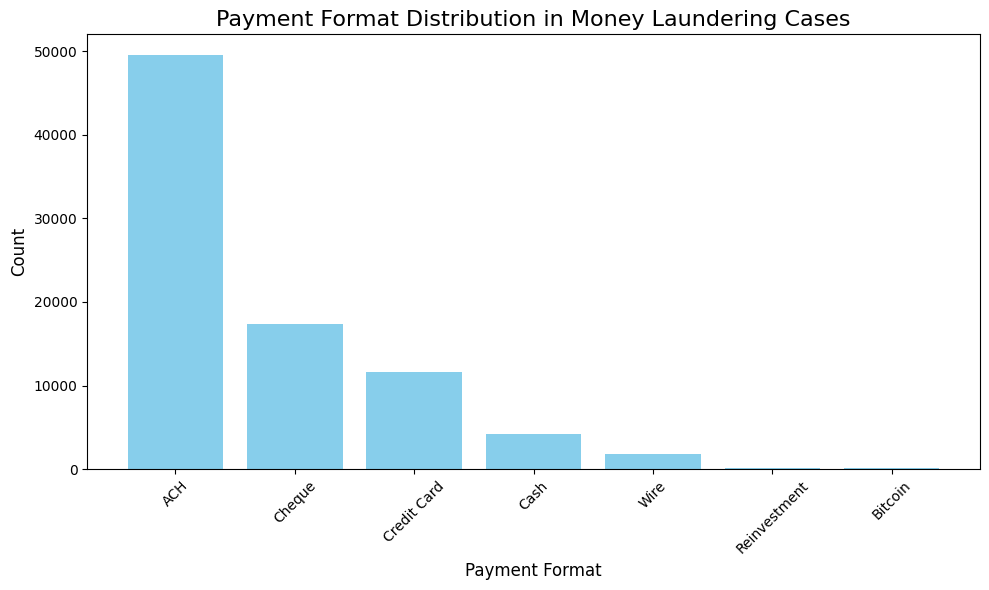

In [51]:
# Filter for money laundering cases
laundering_cases = balanced_df.filter(F.col("isLaundering") == 1)

# Group by Payment_Format and count occurrences
payment_format_counts = (
    laundering_cases.groupBy("Payment_Format")
    .agg(F.count("*").alias("Count"))
    .orderBy(F.desc("Count"))
)

# Collect the data to prepare for plotting
data = payment_format_counts.collect()

# Prepare data for plotting
formats = [row["Payment_Format"] for row in data]
counts = [row["Count"] for row in data]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(formats, counts, color="skyblue")
plt.title("Payment Format Distribution in Money Laundering Cases", fontsize=16)
plt.xlabel("Payment Format", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

### Visualization Currency Distribution in Money Laundering Cases

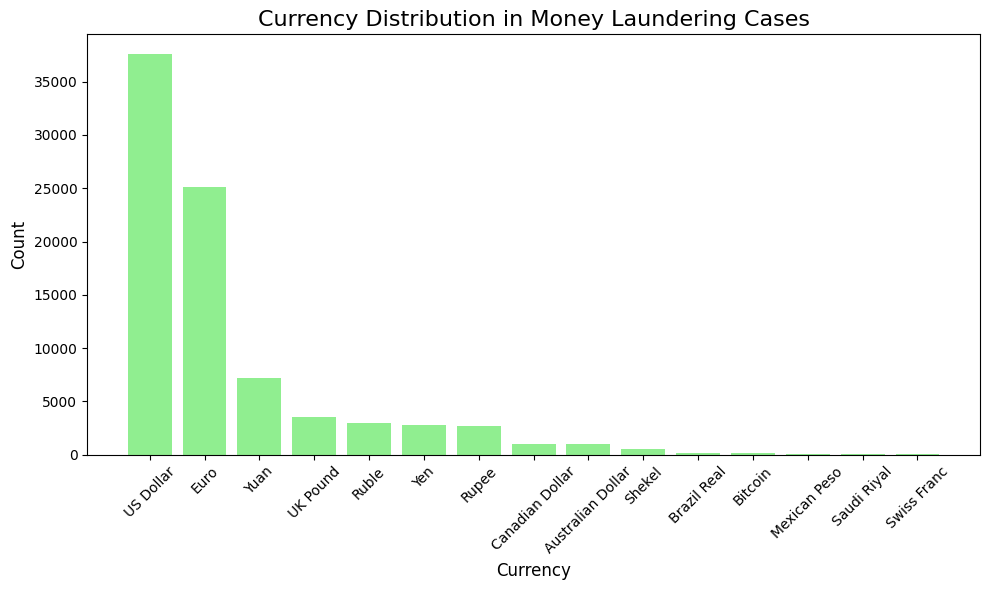

In [52]:
# Filter for money laundering cases
laundering_cases = balanced_df.filter(F.col("isLaundering") == 1)

# Group by Receiving_Currency and count occurrences
currency_counts = (
    laundering_cases.groupBy("Receiving_Currency")
    .agg(F.count("*").alias("Count"))
    .orderBy(F.desc("Count"))
)

# Collect the data to prepare for plotting
data = currency_counts.collect()

# Prepare data for plotting
currencies = [row["Receiving_Currency"] for row in data]
counts = [row["Count"] for row in data]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(currencies, counts, color="lightgreen")
plt.title("Currency Distribution in Money Laundering Cases", fontsize=16)
plt.xlabel("Currency", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

### Feature Engineering¶
Aggregated Features by Account using Window Functions:
Calculate FanOut, FanIn, and AvgAmountSent.

-FanOut:
how many different transactions it initiates.

-FanIn:
how many different transactions it receives.

-AvgAmountSent:
the typical transaction size for each account as a sender.

In [53]:
# Window specifications
sender_window = Window.partitionBy("From_Account")
receiver_window = Window.partitionBy("To_Account")

# Calculate fan-out, fan-in, and average amount sent
featured_df = balanced_df.withColumn("FanOut", count("To_Account").over(sender_window)) \
                         .withColumn("FanIn", count("From_Account").over(receiver_window)) \
                         .withColumn("AvgAmountSent", avg("Amount_Paid").over(sender_window))

In [54]:
balanced_df.unpersist()

#Show the resulting DataFrame
featured_df.show(truncate=False)

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+------+-----+------------------+
|Timestamp          |From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|Hour|DayOfWeek|FanOut|FanIn|AvgAmountSent     |
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+------+-----+------------------+
|2022-09-01 05:46:00|004      |800060A20   |004    |800060A20 |10683.91       |Rupee             |10683.91   |Rupee           |Credit Card   |Unknown     |0           |5   |5        |222   |36   |219080.68385012515|
|2022-09-08 07:13:00|004      |800060A20   |025    |8129D4D00 |595031.7       |Rupee             |595031.7   |Rupee           |Cheque   

####Encode Categorical Variables:

Converted categorical columns into numerical indices using StringIndexer.

In [55]:
currency_index = StringIndexer(inputCol="Receiving_Currency", outputCol="CurrencyIndex")
payment_format_index = StringIndexer(inputCol="Payment_Format", outputCol="PaymentFormatIndex")
pattern_type_index = StringIndexer(inputCol="Pattern_Type", outputCol="PatternTypeIndex")

featured_df = currency_index.fit(featured_df).transform(featured_df)
featured_df = payment_format_index.fit(featured_df).transform(featured_df)
featured_df = pattern_type_index.fit(featured_df).transform(featured_df)

In [56]:
#featured_df.display()

# Show the resulting DataFrame
featured_df.show(truncate=False)

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+------+-----+------------------+-------------+------------------+----------------+
|Timestamp          |From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|Hour|DayOfWeek|FanOut|FanIn|AvgAmountSent     |CurrencyIndex|PaymentFormatIndex|PatternTypeIndex|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+------+-----+------------------+-------------+------------------+----------------+
|2022-09-01 05:46:00|004      |800060A20   |004    |800060A20 |10683.91       |Rupee             |10683.91   |Rupee           |Credit Card   |Unknown     |0           |5   |5        |222   |36   |219080

In [ ]:
# DA ERROR
#size_in_memory_gb = featured_df.rdd.map(lambda row: len(str(row))).sum() / (1024 * 1024 * 1024)
#print(f"Approximate size in memory: ({size_in_memory_gb:.2f} GB)")

### SMOTE to generate synthetic data for minority

Compilado hasta aca la sgte da errores - me truena el servidor Java parece que por falta de memoria !

In [ ]:
'''
# Step 1: Select only the required columns (excluding 'isLaundering')
feature_columns = ["Amount_Received", "FanOut", "FanIn", "AvgAmountSent",
                   "Hour", "DayOfWeek", "CurrencyIndex",
                   "PaymentFormatIndex", "PatternTypeIndex"]

# Select features for minority class (isLaundering = 1)
minority_df = featured_df.filter(F.col("isLaundering") == 1).select(*feature_columns)
majority_df = featured_df.filter(F.col("isLaundering") == 0).select(*feature_columns, "isLaundering")

featured_df.unpersist()

# Step 2: Define a function to generate synthetic samples (excluding isLaundering)
def generate_synthetic_samples(minority_data, num_samples=10):
    synthetic_samples = []

    for row in minority_data:
        base_vector = np.array([row[col] for col in feature_columns])

        # Find random neighbors within the minority class
        neighbors = random.sample(minority_data, k=num_samples)
        for neighbor in neighbors:
            neighbor_vector = np.array([neighbor[col] for col in feature_columns])

            # Interpolate to create a synthetic sample
            gap = np.random.rand()
            synthetic_vector = base_vector + gap * (neighbor_vector - base_vector)

            # Append the synthetic sample without the 'isLaundering' column
            synthetic_samples.append(tuple(synthetic_vector.tolist()))

    return synthetic_samples

# Step 3: Collect minority samples and generate synthetic samples
minority_data = minority_df.collect()
synthetic_samples = generate_synthetic_samples(minority_data, num_samples=50)

# Step 4: Define schema for synthetic samples without 'isLaundering'
schema = StructType([StructField(col, DoubleType(), True) for col in feature_columns])

# Create synthetic DataFrame from synthetic samples
synthetic_df = spark.createDataFrame(synthetic_samples, schema=schema)

# Step 5: Add 'isLaundering' column with value 1 to synthetic samples
synthetic_df = synthetic_df.withColumn("isLaundering", F.lit(1))

# Step 6: Combine the majority and synthetic DataFrames
balanced_featured_df = majority_df.union(synthetic_df)

# Display counts to confirm balancing
balanced_featured_df.cache().groupBy("isLaundering").count().show()

'''

In [59]:
# Step 1: Select required columns
feature_columns = ["Amount_Received", "FanOut", "FanIn", "AvgAmountSent",
                   "Hour", "DayOfWeek", "CurrencyIndex",
                   "PaymentFormatIndex", "PatternTypeIndex"]

# Ensure DataFrame has valid schema and is not empty
if not featured_df.isEmpty():
    # Separate minority and majority classes
    minority_df = featured_df.filter(F.col("isLaundering") == 1).select(*feature_columns)
    majority_df = featured_df.filter(F.col("isLaundering") == 0).select(*feature_columns, "isLaundering")

    featured_df.unpersist()

    # Step 2: Function to generate synthetic samples
    def generate_synthetic_samples(minority_data, num_samples=10):
        synthetic_samples = []
        for row in minority_data:
            base_vector = np.array([row[col] for col in feature_columns])

            # Random neighbors
            neighbors = random.sample(minority_data, min(len(minority_data), num_samples))
            for neighbor in neighbors:
                neighbor_vector = np.array([neighbor[col] for col in feature_columns])
                gap = np.random.rand()
                synthetic_vector = base_vector + gap * (neighbor_vector - base_vector)
                synthetic_samples.append(tuple(synthetic_vector.tolist()))
        return synthetic_samples

    # Step 3: Distributed Synthetic Data Generation
    minority_data = minority_df.rdd.map(lambda row: row.asDict()).collect()
    synthetic_samples = generate_synthetic_samples(minority_data, num_samples=50)

    # Step 4: Define schema and create synthetic DataFrame
    schema = StructType([StructField(col, DoubleType(), True) for col in feature_columns])
    synthetic_df = spark.createDataFrame(synthetic_samples, schema=schema)

    # Add 'isLaundering' column
    synthetic_df = synthetic_df.withColumn("isLaundering", F.lit(1))

    # Step 5: Combine majority and synthetic DataFrames
    balanced_featured_df = majority_df.union(synthetic_df)

    # Cache and confirm balancing
    balanced_featured_df.cache().groupBy("isLaundering").count().show()
else:
    print("Error: 'featured_df' is empty or invalid.")

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
balanced_featured_df.display()

In [ ]:
balanced_featured_df.groupBy("isLaundering").count().display()
#increased minority to 12%

##### Assemble Features into a Vector:

Use VectorAssembler to create a feature vector for model input

In [ ]:
features_col = ["Amount_Received", "FanOut", "FanIn", "AvgAmountSent", "Hour", "DayOfWeek", "CurrencyIndex", "PaymentFormatIndex", "PatternTypeIndex"]
correlation_features = ["Amount_Received", "FanOut", "FanIn", "AvgAmountSent", "Hour", "DayOfWeek", "CurrencyIndex", "PaymentFormatIndex", "PatternTypeIndex", "isLaundering"]
assembler = VectorAssembler(inputCols=correlation_features, outputCol="corr_features")
df_vector = assembler.transform(balanced_featured_df)


##### Correlation Heatmap: To assess relationships between features and identify strong predictors,

In [ ]:
# Calculate correlation matrix
correlation_matrix = Correlation.corr(df_vector, "corr_features").head()[0].toArray()

# Convert to a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, xticklabels=correlation_features, yticklabels=correlation_features, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Observations:

###### Correlation Heatmap:

Amount_Received and AvgAmountSent show a moderately positive correlation (0.34). Including both might introduce some redundancy, but they may still capture distinct aspects of the data.

Other features have relatively low correlations with each other, which generally indicates that they might add unique information to the model.

- PatternTypeIndex Has the strongest positive correlation with
isLaundering (0.89).
- CurrencyIndex Shows a weak positive correlation (0.046) with isLaundering.
- PaymentFormatIndex Also shows a weak positive correlation (0.053) with isLaundering.
- FanOut and DayOfWeek Show negative correlations (-0.087 and -0.067, respectively) with isLaundering.
- Hour and AvgAmountSent Show weak positive correlations (0.014 and 0.053, respectively) with isLaundering.
- Amount_Received Has an extremely weak positive correlation (0.0059) with isLaundering, suggesting it's nearly uncorrelated.
- FanIn Has a weak negative correlation (-0.01) with isLaundering.
#### Key Takeaways:
- PatternTypeIndex is the standout feature, showing a strong correlation with isLaundering. It’s critical to include this in the model.
- Features like CurrencyIndex and PaymentFormatIndex have weak correlations but could still contribute useful information when combined with others.
- Features like Amount_Received, FanIn, and Hour have very weak correlations, and their inclusion should be carefully considered to avoid adding noise to the model.




# Feature Selection

In [ ]:
# Define all features for the final assembler, using scaled and unscaled features
all_features = [ "FanOut", "AvgAmountSent", "DayOfWeek", "CurrencyIndex", "PaymentFormatIndex", "PatternTypeIndex"]

# Assemble the final feature vector for prediction
assembler_final = VectorAssembler(inputCols=all_features, outputCol="features")
balanced_featured_df = balanced_featured_df.select(all_features + ["isLaundering"])

In [ ]:
size_in_memory_gb = balanced_featured_df.rdd.map(lambda row: len(str(row))).sum() / (1024 * 1024 * 1024)
print(f"Approximate size in memory: ({size_in_memory_gb:.2f} GB)")

#####Split the Data:

Split the data into training, validation, and test sets.

In [ ]:
train_df, val_df, test_df = balanced_featured_df.randomSplit([0.6, 0.2, 0.2], seed=42)
balanced_featured_df.unpersist()
train_df.cache()
val_df.cache()
test_df.cache()

##Model Training with Pipeline

#####Created a Pipeline with Random Forest Classifier ML model:

Defined a pipeline to streamline the feature transformations and model training process.

In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol="isLaundering", numTrees=20, maxDepth=10)
pipeline = Pipeline(stages=[ assembler_final, rf])

#####Hyperparameter Tuning using CrossValidator:

-Used CrossValidator to find the best hyperparameters for the Random Forest model.

-BinaryClassificationEvaluator Used to evaluate the model's performance.

-areaUnderROC is a common metric for binary classification, especially useful for imbalanced datasets.

In [ ]:
paramGridSearch = ParamGridBuilder().addGrid(rf.numTrees, [10, 20]).addGrid(rf.maxDepth, [10]).build()
evaluatorr = BinaryClassificationEvaluator(labelCol="isLaundering", metricName="areaUnderROC")
crossvalidation = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGridSearch, evaluator=evaluatorr, numFolds=3)
cvModel = crossvalidation.fit(train_df)


##Evaluate the Model

#####Evaluate on Validation Data:

Used F1 Score, Area Under ROC metrics to evaluate the model on validation data.

In [ ]:
# Evaluate ROC on validation data
predictions = cvModel.transform(val_df)
roc_score = evaluatorr.evaluate(predictions)
print("Area Under ROC Score on validation data:", roc_score)

In [ ]:
# Evaluate F1 Score on validation data
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="isLaundering", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print("F1 Score on validation data:", f1_score


#####Final Testing:

Test the model on the test set to get final performance metrics.

In [ ]:
# Evaluate ROC on test data
final_predictions = cvModel.transform(test_df)
test_roc_score = evaluatorr.evaluate(final_predictions)
print("Final ROC Score on test data:", test_roc_score)

In [ ]:
# Evaluate F1 Score on test data
test_f1_score = evaluator_f1.evaluate(final_predictions)
print("Final F1 Score on test data:", test_f1_score)

In [ ]:
#evaluate percision and recall
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="isLaundering", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="isLaundering", predictionCol="prediction", metricName="weightedRecall")

precision = precision_evaluator.evaluate(final_predictions)
recall = recall_evaluator.evaluate(final_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

### Observations
Unrealistically high performance can result from data leakage. 

This occurs when information from the test data unintentionally influences the training process, making the model seem flawless. For example, using features directly derived from the target variable, such as PatternTypeIndex, can lead to such misleading results.

## Without PatternTypeIndex

In [ ]:
# Define all features for the final assembler, using scaled and unscaled features
all_features = [ "FanOut", "AvgAmountSent", "DayOfWeek", "CurrencyIndex", "PaymentFormatIndex"]

# Assemble the final feature vector for prediction
assembler_final = VectorAssembler(inputCols=all_features, outputCol="features")
balanced_featured_df = balanced_featured_df.select(all_features + ["isLaundering"])

In [ ]:
train_df, val_df, test_df = balanced_featured_df.randomSplit([0.6, 0.2, 0.2], seed=42)

In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol="isLaundering", numTrees=20, maxDepth=10)
pipeline = Pipeline(stages=[ assembler_final, rf])

In [ ]:
paramGridSearch = ParamGridBuilder().addGrid(rf.numTrees, [10, 20]).addGrid(rf.maxDepth, [10]).build()
evaluatorr = BinaryClassificationEvaluator(labelCol="isLaundering", metricName="areaUnderROC")
crossvalidation = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGridSearch, evaluator=evaluatorr, numFolds=3)
cvModel = crossvalidation.fit(train_df)

In [ ]:
# Evaluate ROC on validation data
predictions = cvModel.transform(val_df)
roc_score = evaluatorr.evaluate(predictions)
print("Area Under ROC Score on validation data:", roc_score)

In [ ]:
# Evaluate F1 Score on validation data
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="isLaundering", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print("F1 Score on validation data:", f1_score)


In [ ]:
# Evaluate ROC on test data
final_predictions = cvModel.transform(test_df)
test_roc_score = evaluatorr.evaluate(final_predictions)
print("Final ROC Score on test data:", test_roc_score)

In [ ]:
# Evaluate F1 Score on test data
test_f1_score = evaluator_f1.evaluate(final_predictions)
print("Final F1 Score on test data:", test_f1_score)

In [ ]:
#evaluate percision and recall
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="isLaundering", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="isLaundering", predictionCol="prediction", metricName="weightedRecall")

precision = precision_evaluator.evaluate(final_predictions)
recall = recall_evaluator.evaluate(final_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

## Metrics Overview
### Validation Data:
Area Under ROC (AUC): 0.927

indicates the model separates positive and negative classes well.

F1 Score: 0.963

Suggests a strong balance between precision and recall on validation data.

### Test Data:
Area Under ROC (AUC): 0.928

Similar to validation, indicating consistent performance across datasets.

F1 Score: 0.963

Strong alignment with validation F1, showing generalization capability.

Precision: 0.966

Indicates that 96.6% of the model's positive predictions are correct.

Recall: 0.965

Suggests the model identified 96.5% of actual positive instances.

### Checking feature Importance

In [ ]:
rf_model = cvModel.bestModel.stages[-1]  # Access the trained Random Forest model
importances = rf_model.featureImportances.toArray()
print("Feature Importances:", importances)

### Feature Importance

The feature importances:
- DayOfWeek (1st highest): 0.729 (dominant feature)

- PaymentFormatIndex (2nd highest): 0.143

- AvgAmountSent: 0.063

- CurrencyIndex: 0.032

- FanOut (least important): 0.030

**Analysis**: The model relies heavily on DayOfWeek and PaymentFormatIndex, contributing ~87% of the total importance.

### Analyze the predictions

To ensure the model generalize

In [ ]:
# Count predicted classes
final_predictions.groupBy("prediction").count().show()

In [ ]:
# Calculate confusion matrix
final_predictions.crosstab("isLaundering", "prediction").show()

### Observations
**True Positives (TP):** 617,206 (Correctly identified laundering cases).

**True Negatives (TN):** 6,292,500 (Correctly identified non-laundering cases).

**False Positives (FP):** 16,748 (Misclassified non-laundering as laundering).

    While relatively low compared to true negatives, false positives could cause unnecessary investigations.

**False Negatives (FN):** 231,031 (Missed laundering cases).

    which could be critical in real-world anti-money laundering applications.


In [ ]:
train_df.unpersist()
val_df.unpersist()
test_df.unpersist()